# Insight Project --Birding Big Year--

In this project I intend to determine a way to see all the birds one can see on a single state, for a given time window.  For all those birdirers that want to get to the top 100 of their state on ebrid, this will be the perfect tool. The user will input the state, home address (or lat,lon), time window and birds that already have been seen*. This last one (*) is an optional thing.

In [ ]:
import numpy as np
from datetime import datetime
import geopandas as gpd
import os
import struct
import pickle
import googlemaps
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.cluster import DBSCAN

import SetCover

def save_fig(name):
    fig.savefig(name,dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')

%matplotlib inline

# The ebird Data

I will start with a singe state. Since the ebird API limits the type of request I can make, I have a downloaded the cvs file.  I'm using the last two full years of data but in reality the alorithm should be train with more data and just tested on the last year.

In [ ]:
# dfAll = pd.read_csv('./ebd_US-WY_201801_201912_relApr-2020/ebd_US-WY_201801_201912_relApr-2020.txt'
#                 ,delimiter="\t")

dfAll = pd.read_csv('./ebd_US-WI_201801_201912_relApr-2020/ebd_US-WI_201801_201912_relApr-2020.txt'
                ,delimiter="\t", usecols=['CATEGORY', 'LOCALITY TYPE', 'ALL SPECIES REPORTED', 'APPROVED',
                                         'SAMPLING EVENT IDENTIFIER', 'COMMON NAME', 'LOCALITY', 
                                          'LATITUDE', 'LONGITUDE',
                                          'OBSERVATION DATE', 'ALL SPECIES REPORTED'])

# dfAll = pd.read_csv('./ebd_US-WI_201001_201812_relApr-2020/ebd_US-WI_201001_201812_relApr-2020.txt'
#                 ,delimiter="\t")

I add sertain condition to satify completnes fo the data, public locations and only bird species (i.e. no hybirds). `dfReduce` will contian all the information I will be using.

In [ ]:
dfAll = dfAll[(dfAll['CATEGORY'] == 'species') & (dfAll['LOCALITY TYPE'] == 'H')
              & (dfAll['ALL SPECIES REPORTED'] == 1)  & (dfAll['APPROVED'] == 1)]

In [ ]:
dfReduce = dfAll.filter(['SAMPLING EVENT IDENTIFIER', 'COMMON NAME', 'LOCALITY',
              'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE', 'ALL SPECIES REPORTED']) 
dfReduce['OBSERVATION DATE'] = pd.to_datetime(dfReduce['OBSERVATION DATE'])
dfReduce['YEAR WEEK'] = dfReduce['OBSERVATION DATE'].dt.strftime('%W')
dfReduce['YEAR DAY'] = dfReduce['OBSERVATION DATE'].dt.strftime('%j')
dfReduce['YEAR'] = dfReduce['OBSERVATION DATE'].dt.strftime('%Y')
dfReduce['YEAR WEEK'] = pd.to_numeric(dfReduce['YEAR WEEK'])

In [ ]:
dfReduce.head(5)

dfReduce contains both my train set and my validation set.  In this case I will use the last year as my validation set (2019) and all the previous information as my train set.

In [6]:
dfValidation = dfReduce[dfReduce['YEAR']==2019]

In [7]:
dfTrain = dfReduce[dfReduce['YEAR']!=2019]

In [8]:
del dfReduce
del dfAll

In [9]:
len(np.unique(dfTrain['LOCALITY'].values))

2333

# Clustering using BDSCAN

BDSCAN is a density clustering that will tell where is popular for people to go birding (based on the desnity of hotsopts).  I will define a cluster as having atleast 3 point and with a maximum distance of 0.05degrees or about 5km.  With that I will optain where does each hotspot ('LOCALITY') belongs to. If '-1' they are not part of any cluster.

In [10]:
def cluster_selection(df, eps=0.05, min_samples=3):
    '''
    Calculates for a given geographical region identify in the dataframe, the location of where bird watchers tend to go more often. This does not qualifies the goodness of the locations just that are locations used by birders. A bird watching cluster is defined by having at least 3 birding locations all up to 5km apart (eps =0.05) 
    
    Arg:
        df: The data frame of the geographical region, from it both latitude and longitude will be use to determine the clusters
        eps: Max separation between points in the BDSCAN clustering algorithm. eps = 0.01~1km
        min_sample: A cluster need to have atleast 3 birding spots.  
        
    Out:
        dfcluster = Data frame with the latitude,logitude, location name and cluster ID for all the points in the region.
    
    
    '''
    dfcluster = df.filter(['LOCALITY','LATITUDE', 'LONGITUDE'])
    dfcluster.drop_duplicates(subset='LATITUDE', keep = 'first', inplace = True)
    locationList = np.array((dfcluster['LATITUDE'],dfcluster['LONGITUDE'])).T
    
    dbmod = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(locationList)
    
    labels = dbmod.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    dfcluster['BD CLUSTER'] = labels

In [11]:
dfbdscan = dfTrain.filter(['LOCALITY','LATITUDE', 'LONGITUDE'])

In [12]:
dfbdscan.drop_duplicates(subset='LATITUDE', keep = 'first', inplace = True)

In [13]:
dfbdscan.head(5)

,LOCALITY,LATITUDE,LONGITUDE
3,Riverside Park (Urban Ecology Center),43.067967,-87.892686
4,Schlitz Audubon Nature Center,43.175688,-87.890421
5,Manitowoc Lakefront,44.092794,-87.650170
15,UW Lakeshore Nature Preserve--Willow Creek Woo...,43.077869,-89.421544
16,County V Ponds (Dane Co.),43.247843,-89.429111


In [34]:
locationList = np.array((dfbdscan['LATITUDE'],dfbdscan['LONGITUDE'])).T

In [15]:
eps = .05
dbmod = DBSCAN(eps=eps, min_samples=3, metric='euclidean').fit(locationList)

In [38]:
dbmod.components_

array([[ 43.0679668, -87.8926859],
       [ 43.1756879, -87.8904211],
       [ 44.0927942, -87.6501703],
       ...,
       [ 42.8602058, -87.9141319],
       [ 42.758241 , -88.707341 ],
       [ 44.8325   , -87.3433256]])

In [17]:
labels = dbmod.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
core_samples_mask = np.zeros_like(dbmod.labels_, dtype=bool)
core_samples_mask[dbmod.core_sample_indices_] = True

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 137
Estimated number of noise points: 567


In [18]:
unique_labels = set(labels)
colors = [plt.cm.viridis_r(each)
          for each in np.linspace(0, 1, len(unique_labels))]


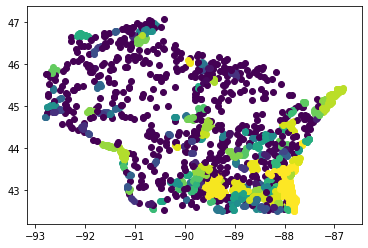

In [19]:
for i, clust in enumerate(labels):
    plt.scatter(locationList[i][1],locationList[i][0], color = colors[clust])
plt.show()

In [20]:
dfbdscan['BD CLUSTER'] = dbmod.labels_

In [21]:
dfbdscan.head(5)

,LOCALITY,LATITUDE,LONGITUDE,BD CLUSTER
3,Riverside Park (Urban Ecology Center),43.067967,-87.892686,0
4,Schlitz Audubon Nature Center,43.175688,-87.890421,0
5,Manitowoc Lakefront,44.092794,-87.650170,1
15,UW Lakeshore Nature Preserve--Willow Creek Woo...,43.077869,-89.421544,2
16,County V Ponds (Dane Co.),43.247843,-89.429111,2


In [22]:
def hotspot_finder_for_dbcluster(k, df, dfbdscan):
    dfIntermediate = df[df['LOCALITY'].isin(list(dfbdscan[dfbdscan['BD CLUSTER'] == k]['LOCALITY']))].groupby(['LOCALITY','COMMON NAME']).sum().filter(['ALL SPECIES REPORTED'])
    dfIntermediate['BIRD'] = list(map(lambda x: 1 if x < 1e6 else 1, dfIntermediate['ALL SPECIES REPORTED']))
    location  = dfIntermediate.filter(['BIRD']).reset_index().groupby(['LOCALITY']).sum().reset_index().sort_values(by='BIRD', ascending=False).reset_index()['LOCALITY'][0]
    lat = df[df['LOCALITY']==location].reset_index()['LATITUDE'][0]
    lon = df[df['LOCALITY']==location].reset_index()['LONGITUDE'][0]
    
    return location, lat, lon

In [23]:
coorHotspot = np.empty((n_clusters_, 2))
for i in range(0, n_clusters_):
    a, coorHotspot[i, 0], coorHotspot[i, 1] = hotspot_finder_for_dbcluster(i, dfTrain, dfbdscan)

In [24]:
n_clusters_

137

### Now some good plots

In [ ]:
country = gpd.read_file('/Users/casanova/DocumentsHere/Insight/gz_2010_us_040_00_5m.json')

In [ ]:
# state = 'Wyoming'
state = 'Wisconsin'

In [ ]:
fig, ax = plt.subplots(1, figsize=(7,8))
base = country[country['NAME'].isin([state]) == True].plot(ax=ax, color='#3B3C6E', alpha = 0.3)
for i, clust in enumerate(labels):
    ax.scatter(locationList[i][1],locationList[i][0], color = colors[clust])
ax.scatter(coorHotspot[:,1],coorHotspot[:,0], marker = 'x', color = 'r', s=80)
ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')

plt.show()
save_fig('/Users/casanova/DocumentsHere/Insight/{}-plain.png'.format(state))

#### Now the bird probability.

`dfbdscan` have the information of where each of the hotspots lay, in terms of their cluster.  Now in order to constuct a path is important to mask the probabilites of the of seeing a particular bird with T or F on a weekly basis.  This is critical in order to construc the sets.

In [ ]:
dfProb = dfTrain.merge(dfbdscan.filter(['LOCALITY','BD CLUSTER']),
                            left_on='LOCALITY', right_on='LOCALITY', how = 'left').filter(['COMMON NAME','ALL SPECIES REPORTED','YEAR WEEK', 'BD CLUSTER'])

In [ ]:
dfProb.head(5)

In [ ]:
nTime = 54
nLoc = n_clusters_
setMat = np.empty((nTime,nLoc), dtype=object)

In [ ]:
for week in range(0,nTime):
    dfProbA = dfProb[dfProb['YEAR WEEK']== week]
    dfProb1 = dfProbA.groupby(['COMMON NAME','BD CLUSTER']).sum().filter(['ALL SPECIES REPORTED']).reset_index()
    dfProb1.rename(columns = {'ALL SPECIES REPORTED':'POS OBS'}, inplace=True)
    dfProb2 = dfProbA.groupby(['BD CLUSTER']).sum().filter(['ALL SPECIES REPORTED']).reset_index()
    dfProb2.rename(columns = {'ALL SPECIES REPORTED':'TOT OBS'}, inplace=True)
    dfProb3 = dfProb1.merge(dfProb2, left_on='BD CLUSTER', right_on='BD CLUSTER', how = 'left')
    dfProb3['POS PROB'] = dfProb3['POS OBS']/dfProb3['TOT OBS']
    for loc in range(0,nLoc):
        dfWeek = dfProb3[dfProb3['BD CLUSTER'] == loc]
        dfWeek['TF aa'] = list(map(lambda x: 0 if x < 0.02 else 1, dfWeek['POS PROB']))
        setMat[week,loc] = set(dfWeek[dfWeek['TF aa'] == 1]['COMMON NAME'].values)
        

In [ ]:
pickle.dump(setMat, open("./2dSetLocations.p", "wb" ))

In [ ]:
ToMakeUniverse = list(setMat.flatten())
Universe = set(e for s in ToMakeUniverse for e in s)

In [ ]:
# list(Universe)

# Here we go!!!!!

First user inputs some coordinates.
Then the coordinates get translated to a cluster.
That give us the first set (first week)
Then we obtain the rest of the sets. The key here is to back track a set to an actual 'x,t' entry so we can have a route.
Display in some way that list of locations!  (Probabily using the centroid maps or coordinates).

In [ ]:
# userInputLat,userInputLon = 44, -110
userInputLat,userInputLon = 43.069511, -89.396723

userInput = [userInputLat,userInputLon]
print(userInput)

On the first week I most see:

In [ ]:
setMatLoaded = pickle.load(open("./2dSetLocations.p", "rb" ))

The hole list of bird that we are planing to see are:

In [ ]:
ToMakeUniverse = list(setMatLoaded.flatten())
Universe = set(e for s in ToMakeUniverse for e in s)

In [ ]:
print('With a total of', len(list(Universe)), 'birds')

In [ ]:
setList, locList = SetCover.set_cover_greedy(Universe, ToMakeUniverse)


In [ ]:
locList = np.sort(locList)

In [ ]:
nTime, nLoc = setMatLoaded.shape
locMat = np.linspace(1,nTime*nLoc,nTime*nLoc).reshape(nTime,nLoc)

In [ ]:
outList = []
for element in locList:
    a,b = np.where(locMat == element)
    outList.append('On week {}, you need to be at location {}'.format(a[0],b[0]))
    

In [ ]:
outList

# Plaing with google distances

In [ ]:
gmaps = googlemaps.Client(key='')

In [ ]:
distMat = np.empty((nTime,n_clusters_))
countBreak = divmod(n_clusters_,100)

for i in range(0,countBreak[0]):
    distanceMatGmaps = gmaps.distance_matrix(origins = (userInput[0],userInput[1]), 
                                         destinations=list(coorHotspot[100*i:100*(i+1)]),
                                         mode = 'driving', units = 'metric')
    for j in range(100*i,100*(i+1)):
        jj = j - 100*i
        try:
            distMat[:,j] = distanceMatGmaps['rows'][0]['elements'][jj]['duration']['value']/3600
        except KeyError:
            distMat[:,j] = 100
        
distanceMatGmaps = gmaps.distance_matrix(origins = (userInput[0],userInput[1]), 
                                         destinations=list(coorHotspot[countBreak[0]*100:]),
                                         mode = 'driving', units = 'metric')

for j in range(countBreak[0]*100,countBreak[0]*100+countBreak[1]):
    jj = j - countBreak[0]*100
    try:
        distMat[:,j] = distanceMatGmaps['rows'][0]['elements'][jj]['duration']['value']/3600
    except KeyError:
        distMat[:,j] = 100

In [ ]:
distMat

In [ ]:
import importlib
importlib.reload(SetCover)

In [ ]:
a, b = SetCover.set_cover_weighted_greedy(Universe, ToMakeUniverse,list(distMat.flatten()))

In [ ]:
locListb = np.sort(b)

In [ ]:
locListb

In [ ]:
outList = []
for element in locListb:
    a,b = np.where(locMat == element)
    outList.append('On week {}, you need to be at location {}'.format(a[0],b[0]))

In [ ]:
outList